In [39]:
import os
import glob
import pandas as pd
import numpy as np
from itertools import product
import importlib.util
import frictionless

# 20210223

The goal of this notebook is to address the data normalization problem with files in [../data/all_stab_scores](../data/all_stab_scores). In short, I want to partition stability score CSV files such that each partition has its own Data Resource and schema. The columns in schema should be as "close" to the non-empty columns in the files of the partition as possible. At the same time, we want as few partitions as possible (otherwise, optimal solution would be a single Data Resource for each CSV file).

Continuation of [20210222](./20210222.ipynb) notebook.

----

From today's vimwiki entry:
> * We could start with a base case where each node has its own subgraph.
>    * Merging subgraphs is defined as taking the union of each subgraph's column set
>        * This is a favorable operation if the subgraphs have "substantially similar" column sets.
>        * "Substantially similar" could be defined as length of intersection divided by the length of the union. This metric takes a value between 0 and 1, with 1 being optimal.
>        * We could set a threshold for the minimum allowed "overlap metric" for a merging operation.
>    * The existence of an edge between subgraphs that are not merged is an alternative.
>        * This represents a column that would be shared between two subgraphs (tables).
>        * An edge with a small weight is the best case, since we could simply add this column to both subgraphs' sets.
>        * This operation is optimal when the size of the intersection is minimal compared with the size of the union: in other words, a small "overlap metric".
>    * We choose either this "merging two subgraphs" operation or the "add small weight edges to both subgraphs" operation until we reach a state where nodes within a subgraph have high overlap, and there exist no edges between separate subgraphs.
>    * An input parameter "overlap threshold" would determine at which point a merging operation vs an add-edge operation should be performed. Intuitively, a good starting value is 0.5, though a different value might be optimal.
>    * How do we define the optimal solution? In general, we want:
>        * Mean Ix(i) / U(s) maximized for each node i in subgraph s
>        * Ix / U between subgraphs is, by definition of the termination condition, zero.
>    * So this is more of a set problem than a graph problem, but put succinctly:
>        * We want to find "overlap threshold" s.t. we minimize the mean Intersection / Union(s) for each subgraph s.
>    * Unfortunately, it is quite possible that the final solution will contain only one subset that spans the entire set.
>* Implementation
>    * We start with a list of subsets, one for each file.
>        * A subset could be represented as a dict with two items:
>            * Which nodes are in the subset
>            * The union of all nodes' columns in the subset.
>    * For each unique combination of subsets, calculate the overlap metric (p)
>        * Given column sets c1 and c2 for a pair of subsets s1 and s2, this is equel to `len(s1.intersection(s2)) / len(s1.union(s2))`
>    * If p equals zero for a pair of subsets, ignore this pair.
>        * This means that
>        * Our work is done for this pair of subsets.
>    * Else if p > thresh, then merge the subsets
>    * Else, add every column in the intersection to both subsets' columns

In [40]:
primary_keys = ['dataset', 'name', 'chip_name']

ERROR! Session/line number was not unique in database. History logging moved to new session 382


In [41]:
all_fps = glob.glob("../data/all_stab_scores/og/*.csv")

In [42]:
def get_cols(fp, primary_keys: list = primary_keys) -> list:
    """Get columns in CSV file `fp`, and remove primary keys"""
    all_cols = pd.read_csv(fp).columns.tolist()
    return [c for c in all_cols if c not in primary_keys]
col_dict = {int_idx: get_cols(fp) for int_idx, fp in enumerate(all_fps)}

/Users/TASethanho/anaconda3/envs/frictionless/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
subs = [{'files': set([int_idx]), 'cols': set(get_cols(fp))} for int_idx, fp in enumerate(all_fps)]

In [44]:
len(subs)

24

Iterate over every unique combination of subsets:

In [45]:
def optimal_subsets(subs, olap_thresh=0.5, verbose=False):
    """"""
    s = list(subs)
    merge_event = True
    n_iters = 0
    while merge_event:
        # we terminate if no merge event occured this iteration
        merge_event = False
        
        # iterate over every unique combination of subsets
        for i in range(len(s)):
            for j in range(i + 1, len(s)):
                s1 = s[i]
                s2 = s[j]
                
                # skip if one of the subsets was already merged
                # (now an empty dictionary)
                if not s1 or not s2:
                    continue
                
                # compute ratio of intersection size to union size
                olap = len(s1['cols'].intersection(s2['cols'])) / len(s1['cols'].union(s2['cols']))
                
                if olap == 0:
                    # skip if sets are completely distinct
                    continue
                elif olap > olap_thresh:
                    # merge s2 into s1
                    s1['files'] = s1['files'].union(s2['files'])
                    s1['cols'] = s1['cols'].union(s2['cols'])
                    # we replace the merged subset with empty dict
                    s[j] = dict()
                    merge_event = True
        # remove empty dictionaries (merged sets) from the subsets list
        s = [sub for sub in s if sub]
        n_iters += 1
    if verbose:
        print(f"executed {n_iters} merging iterations")
    return s

In [46]:
opt = optimal_subsets(subs, 0.4)
for s1, s2 in product(*[opt] * 2):
    if s1['files'] == s2['files']:
        continue
    ix = s1['files'].intersection(s2['files'])
    assert len(ix) == 0, (s1['files'], s2['files'])
len(opt)

3

Wow, this actually appeared to work.

A metric we are interested in is the mean similarity between the columns in each file and the columns in the schema (the subset that contains these files). This will essentially represent the proportion of columns in each file that will have non-null values. We can use a modified "overlap ratio" for this purpose:

In [47]:
def get_df_from_optimal_subs(subs, optimal_subs, all_fps, col_dict) -> pd.DataFrame:
    rows = list()
    # df = pd.DataFrame(columns=['file_idx', 'group_idx', 'file_path', 'n_cols', 'subset_ix', 'subset_un'])
    for group_idx, subset in enumerate(optimal_subs):
        sub_cols = subset['cols']
        for file_idx in subset['files']:
            cols = set(col_dict[file_idx])
            rows.append({
                'file_idx': file_idx,
                'group_idx': group_idx,
                'file_path': all_fps[file_idx],
                'n_cols': len(cols),
                # by definition, equivalent to n_cols
                # 'subset_ix': len(cols.intersection(sub_cols)),
                'subset_un': len(cols.union(sub_cols)),
            })
    as_df = pd.DataFrame(rows)
    as_df.set_index('file_idx', inplace=True)
    as_df['olap'] = as_df.n_cols / as_df.subset_un
    return as_df

opt_df = get_df_from_optimal_subs(subs, opt, all_fps, col_dict)
opt_df

,group_idx,file_path,n_cols,subset_un,olap
file_idx,,,,,
0,0,../data/all_stab_scores/og/topology_mining_rd2...,88,128,0.687500
1,0,../data/all_stab_scores/og/181114_IL_binders_F...,87,128,0.679688
3,0,../data/all_stab_scores/og/Rocklin_scrambled_c...,88,128,0.687500
4,0,../data/all_stab_scores/og/Rocklin_display_vec...,88,128,0.687500
6,0,../data/all_stab_scores/og/Eva1_scrambled_cont...,111,128,0.867188
9,0,../data/all_stab_scores/og/100K_winter19.v3.ex...,112,128,0.875000
11,0,../data/all_stab_scores/og/Longxing_scrambled_...,104,128,0.812500
14,0,../data/all_stab_scores/og/TwoSix_100K.v4.expe...,115,128,0.898438
16,0,../data/all_stab_scores/og/optE1.v2.experiment...,94,128,0.734375


Overall, this worked pretty well. It looks like the algorithm separated the older Rocklin datasets from the more recent ones. The lone `Benjamin` file in group 2 should probably be merged to group 0 (I suspect this is just a column naming issue).

Not a column naming issue, just because this file only has one data column `stabilityscore`. In general, the algorithm returns the desired result for cases like these, but we'll manually assign it as group 0:

In [48]:
opt_df.loc[19, 'group_idx'] = 0

Finally, let's look at the distribution of overlap ratio for each group:

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

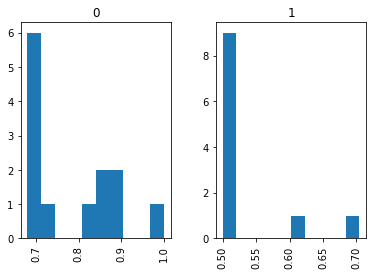

In [49]:
opt_df.hist(column='olap', by='group_idx')

We notice that the overlap metric is over 0.5 for all data files! With the exception of the file we just manually moved.

# Normalize and Write Tables

----

Use the `normalize_csv` utilities to write normalized CSVs for each group. First, load the `normalize_csv` module:

In [50]:
spec = importlib.util.spec_from_file_location("module.name", "../scripts/normalize_csv.py")
normalize_csv = importlib.util.module_from_spec(spec)
spec.loader.exec_module(normalize_csv)

A lightweight wrapper around `normalize_csv.main`:

In [57]:
def normalize_group(norm_group, df, out_dir):
    print(f"Normalizing files in group '{norm_group}'")
    files = df['file_path'][df.group_idx == norm_group].tolist()
    normalize_csv.main(files=files, out_dir=out_dir, overwrite=True, sort_cols=True)

Normalize each group separately:

In [59]:
normalize_group(0, opt_df, '../data/stab_scores')
normalize_group(1, opt_df, '../data/stab_scores_legacy')

Normalizing files in group '1'


/Users/TASethanho/anaconda3/envs/frictionless/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (89) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Normalizing files in group '1'


Hacky check for column number below:

In [53]:
for fp in glob.glob(os.path.join('../data/stab_scores', "*_normalized.csv")):
    df = pd.read_csv(fp)
    expected_ncols = opt_df[opt_df.group_idx == 1]['subset_un'].iloc[0] + 2
    # assert len(df.columns) == expected_ncols, (len(df.columns), expected_ncols)

/Users/TASethanho/anaconda3/envs/frictionless/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (127) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Sanity check:

In [54]:
assert not opt_df.duplicated('file_path').any()

----

To generate schemas for each group, I used the Frictionless CLI to infer a schema for a candidate file in group 0:
```bash
$ frictionless describe --json data/stab_scores/100K_winter19.v3.experimental_stability_scores_normalized.csv | jq -r .schema

# likewise for group 1
$ frictionless describe --json data/stab_scores/Rocklin.v6.experimental_stability_scores_normalized.csv | jq -r .schema
```

Note that the inferred schema **should** be the same for every file in a given group.

Below if a brief reminder of how to describe data using the Python API:

In [55]:
for fp in glob.glob(os.path.join('../data/stab_scores', "*_normalized.csv")):
    fields = frictionless.describe(fp)['schema']['fields']
    print(f"file {fp} has {len(fields)} fields in the schema")

file ../data/stab_scores/Rocklin_ssm_stability_scores.experimental_stability_scores_normalized.csv has 46 fields in the schema
file ../data/stab_scores/Rocklin.rd2.v4.experimental_stability_scores_normalized.csv has 46 fields in the schema
file ../data/stab_scores/optE1_scrambled_controls.experimental_stability_scores_normalized.csv has 131 fields in the schema
file ../data/stab_scores/topology_mining_rd2.experimental_stability_scores_normalized.csv has 131 fields in the schema
file ../data/stab_scores/Rocklin.v6.experimental_stability_scores_normalized.csv has 46 fields in the schema
file ../data/stab_scores/Rocklin.rd3.v4.experimental_stability_scores_normalized.csv has 46 fields in the schema
file ../data/stab_scores/Eva2_scrambled_controls.v3.experimental_stability_scores_normalized.csv has 131 fields in the schema
file ../data/stab_scores/TwoSix_100K.v4.experimental_stability_scores_normalized.csv has 131 fields in the schema
file ../data/stab_scores/Longxing_scrambled_controls.v3

Some of the normalized CSVs, such as `data/stab_scores/100K_winter19.v3.experimental_stability_scores_normalized.csv`, surpassed GitHub's 100MB maximum file size. I halved these large files using vim, though a Python utility could easily do this in production.

In [56]:
opt_df[opt_df['group_idx'] == 1]['file_path'].tolist()

['../data/all_stab_scores/og/Inna.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd1.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva2.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd3.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd4.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.rd2.v4.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Eva1.v7.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin_ssm_stability_scores.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Rocklin.scrambled.experimental_stability_scores.v2.csv',
 '../data/all_stab_scores/og/Rocklin.v6.experimental_stability_scores.csv',
 '../data/all_stab_scores/og/Longxing.v10.experimental_stability_scores.csv']